In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import helpfunction as helper
from __future__ import division

Welcome to JupyROOT 6.10/08


In [2]:
#inputdir = '/home/tmettler/Desktop/ub_data/ub_xsec/ConsolidatedSliceAnalyser/ext/'

# CRTinBNB tagger, Overlay or MC

In [3]:
fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [5,5,5,5,5,5]

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]


mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

gr = (1 + 5 ** 0.5) / 2

In [4]:
def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

def inTPC_mask(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    mask = inTPC_mask(df, str_x, str_y, str_z, fidvol)
    return df[mask]

In [5]:
inputdir = '/home/tmettler/Desktop/ub_data/cc_filter/data_numu/'
outputdir = '/home/tmettler/Desktop/ub_data/cc_filter/data_numu/plots/'

try:
    os.stat(outputdir)
except:
    os.mkdir(outputdir)

filename = 'NuCCana_1_QP_OverlayV13_all.root' 

isMC = 1
tree_name = 'NuCCana'

In [6]:
test = ROOT.TChain(tree_name + "/event","event")
test.Add( inputdir + filename)

#test.ls()
print "Number of Entries:", test.GetEntries()
# uncomment one of them
cutname = 'has_nuslice'

cut = ' && ' + cutname
#cut = ''

title_cut = ''
if(cut!=''):
    title_cut = ' with '+ cutname
    

Number of Entries: 238873


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [7]:
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("","",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [8]:
file_tree = {}
dict_names = ['overlay','on','off']

file_tree['overlay'] = {}
file_tree['overlay']['event'] = uproot.open(inputdir+filename)[tree_name+'/event']

print 'length of event tree', file_tree['overlay']['event'].numentries

length of event tree 238873


In [9]:
for name in file_tree['overlay'] :
    print
    print('*** ', name, ' ***')
    print([c.decode('UTF-8') for c in file_tree['overlay'][name].keys()])


('*** ', 'event', ' ***')
[u'NuScore', u'NuPDG', u'NumPfp_', u'Nu_Vx', u'Nu_Vy', u'Nu_Vz', u'Vx', u'Vy', u'Vz', u'TrackScore', u'VtxDistance', u'TrackLength', u'TrackPID_chiproton', u'TrackPID_chipion', u'TrackPID_chikaon', u'TrackPID_chimuon', u'NuTracks', u'NuShowers', u'nr_crthit', u'crthit_ts0', u'crthit_ts1', u'adc_length', u'crt_adc', u'TriTim_sec', u'TriTim_nsec', u'TimFla', u'flash_PE', u'flash_y', u'flash_z', u'crtt0_time', u'crtt0_trig', u'crtt0_DCA', u'crtt0_plane', u'MCNu_Interaction', u'MCNu_CCNC', u'MCNu_PDG', u'MCNu_Energy', u'MCNu_leptonPx', u'MCNu_LeptonEnergy', u'MCNu_leptonTheta', u'MCNu_time', u'MCNu_Vx', u'MCNu_Vy', u'MCNu_Vz', u'MCNu_VxSce', u'MCNu_VySce', u'MCNu_VzSce', u'MCNu_vertexDistance', u'MCle_PDG', u'MCle_Energy', u'MCle_Vx', u'MCle_Vy', u'MCle_Vz', u'MCle_length', u'MCle_VxSce', u'MCle_VySce', u'MCle_VzSce']


In [10]:
entry_Event = file_tree['overlay']['event'].keys()
#print entry_Event
cols = ['NuScore', 'NuPDG', 'NumPfp_', 'Nu_Vx', 'Nu_Vy','Nu_Vz', 'Vx', 'Vy', 'Vz',\
        'TrackScore','VtxDistance','TrackLength','TrackPID_chiproton', 'TrackPID_chipion', 'TrackPID_chikaon',\
       'TrackPID_chimuon', 'NuTracks', 'NuShowers',\
        'MCNu_CCNC','MCNu_PDG','MCNu_Energy','MCNu_LeptonEnergy','MCNu_leptonTheta','MCNu_Vx','MCNu_Vy','MCNu_Vz',\
       'MCle_PDG','MCle_Energy','MCle_length']
tree_Event = file_tree['overlay']['event'].pandas.df(cols)

tree_Event['mc_nu_fid_vol'] = inTPC_mask( tree_Event, 'MCNu_Vx', 'MCNu_Vy', 'MCNu_Vz', fidvol=fidvol_vtx)
nu_tpc_mask = inTPC_mask( tree_Event, 'MCNu_Vx', 'MCNu_Vy', 'MCNu_Vz',fidvol=fidvol_vtx)
nu_sig_mask = tree_Event.eval('~MCNu_CCNC & abs(MCNu_PDG)==14 & mc_nu_fid_vol')
tree_Event['nu_sig_mask'] = tree_Event.eval('~MCNu_CCNC & abs(MCNu_PDG)==14 & mc_nu_fid_vol')
nu_sig_mask_nue = tree_Event.eval('~MCNu_CCNC & abs(MCNu_PDG)==12 & mc_nu_fid_vol')
print 'Total number of events:', file_tree['overlay']['event'].numentries
print 'Total events with vertex in active volume:', sum(nu_tpc_mask)
print 'Total events numu cc:', sum(nu_sig_mask)
print 'Total events nue cc:', sum(nu_sig_mask_nue) 

Total number of events: 238873
Total events with vertex in active volume: 63329
Total events numu cc: 52066
Total events nue cc: 335


In [11]:
start_mask = inTPC_mask(tree_Event, 'Vx', 'Vy', 'Vz', fidvol_vtx)

In [12]:
tree_Event['start_contained'] = start_mask
#print len(tree_Daughter)
tree_Event_nuCC = tree_Event.query('nu_sig_mask')

query_event = 'NuPDG==14 & start_contained'
query_event = query_event +' & TrackLength>20'
# additinal cuts:
add_query = '& TrackScore>0.97 & VtxDistance<5'
query_event += add_query
eff = len(tree_Event_nuCC.query(query_event))
query_event_pur = query_event + '& MCle_PDG==13'
pur = len(tree_Event_nuCC.query(query_event_pur))
print query_event
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)

add_query = '& NuScore>0.087 '
query_event += add_query
eff = len(tree_Event_nuCC.query(query_event))
query_event_pur = query_event + '& MCle_PDG==13'
pur = len(tree_Event_nuCC.query(query_event_pur))
print
print add_query
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)

add_query = '& (TrackPID_chimuon/TrackPID_chiproton)<0.12'
query_event += add_query
eff = len(tree_Event_nuCC.query(query_event))
qquery_event_pur = query_event + '& MCle_PDG==13'
pur = len(tree_Event_nuCC.query(query_event_pur))
print
print add_query
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)

add_query = '& TrackPID_chiproton>100 & TrackPID_chimuon<20 '
query_event += add_query
eff = len(tree_Event_nuCC.query(query_event))
query_event_pur = query_event + '& MCle_PDG==13'
pur = len(tree_Event_nuCC.query(query_event_pur))
print
print add_query
print "selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)
print 
print 'number of initial events:', sum(nu_sig_mask)
print "number of selected events: {}".format(eff),"- {0:0.1f}%".format(eff*100.0/sum(nu_sig_mask)),\
        " purity: {0:0.1f}%".format(pur*100.0/eff)
#print 'number of selected events:', eff, eff*100.0/sum(nu_sig_mask)

eff_final = eff/sum(nu_sig_mask)
pur_final = pur/eff
print eff_final
print pur_final


NuPDG==14 & start_contained & TrackLength>20& TrackScore>0.97 & VtxDistance<5
selected events: 33669 - 64.7%  purity: 85.6%

& NuScore>0.087 
selected events: 30869 - 59.3%  purity: 86.7%

& (TrackPID_chimuon/TrackPID_chiproton)<0.12
selected events: 26807 - 51.5%  purity: 99.9%

& TrackPID_chiproton>100 & TrackPID_chimuon<20 
selected events: 22463 - 43.1%  purity: 94.2%

number of initial events: 52066
number of selected events: 22463 - 43.1%  purity: 94.2%
0.431433180963
0.94190446512


The denominator (52066,)
The nominator (22463,)


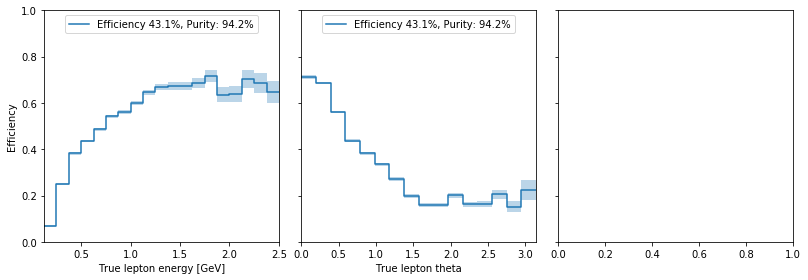

In [13]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharey=True)
purity = pur_final
eff = eff_final
x_min = 0.125
x_max = 2.5
N = 19
denom = tree_Event['MCNu_LeptonEnergy'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Event_nuCC.query(query_event)['MCNu_LeptonEnergy']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton energy [GeV]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[0].legend(loc='upper center')

# middle
#x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
#x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
x_min = 0
x_max = np.pi
N = 16
denom = tree_Event['MCNu_leptonTheta'][nu_sig_mask]
nom = tree_Event_nuCC.query(query_event)['MCNu_leptonTheta']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton theta')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[1].legend(loc='upper center')
#ax[1].set_xticks(x_ticks)
#ax[1].set_xticklabels(x_labels)

# Right
#x_ticks = [np.pi, -np.pi/2, 0, np.pi/2, np.pi]
#x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
'''
x_min = -np.pi
x_max = np.pi
N = 16
denom = np.arctan( tree_Event.query('mc_nu_lepton_py>0')['mc_nu_lepton_py'][nu_sig_mask]\
                  / tree_Event.query('mc_nu_lepton_py>0')['mc_nu_lepton_px'][nu_sig_mask] )
denom1 = np.arctan( tree_Event.query('mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_py'][nu_sig_mask]\
                  / tree_Event.query('mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_px'][nu_sig_mask] ) + np.pi
denom2 = np.arctan( tree_Event.query('mc_nu_lepton_py<0& mc_nu_lepton_px<0')['mc_nu_lepton_py'][nu_sig_mask]\
                  / tree_Event.query('mc_nu_lepton_py<0& mc_nu_lepton_px<0')['mc_nu_lepton_px'][nu_sig_mask] ) - np.pi

nom = np.arctan( tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py>0')['mc_nu_lepton_py']\
                / tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py>0')['mc_nu_lepton_px'] )
nom1 = np.arctan( tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_py']\
                / tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px>0')['mc_nu_lepton_px'] ) + np.pi
nom2 = np.arctan( tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px<0')['mc_nu_lepton_py']\
                / tree_Daughter_nuCC.query(query_event+'&mc_nu_lepton_py<0 & mc_nu_lepton_px<0')['mc_nu_lepton_px'] ) - np.pi

nom = nom.append(nom1)
nom = nom.append(nom2)
denom = denom.append(denom1)
denom = denom.append(denom2)
print nom.shape
print denom.shape

data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[2].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[2].set_xlabel(r'True lepton theta')
ax[2].set_ylim(0,1)
ax[2].set_xlim(x_min, x_max)
ax[2].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[2].legend(loc='upper center')
#ax[2].set_xticks(x_ticks)
#ax[2].set_xticklabels(x_labels)
'''

fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")
fig.savefig(outputdir+"eff.png", bbox_inches="tight")

The denominator (52066,)
The nominator (22463,)
The denominator (52066,)
The nominator (22463,)
The denominator (52066,)
The nominator (22463,)


/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


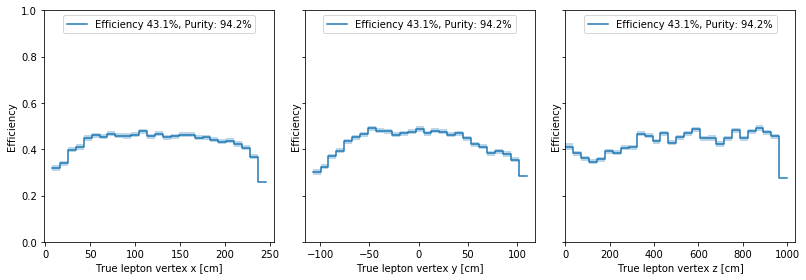

In [14]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4), sharey=True)
#lower = [-1.55, -115.53, 0.1]
#upper = [254.8, 117.47, 1036.9]
purity = pur_final
eff = eff_final
x_min = -1.55
x_max = 254.8
N = 29
denom = tree_Event['MCNu_Vx'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Event_nuCC.query(query_event)['MCNu_Vx']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton vertex x [cm]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[0].legend(loc='upper center')

# Right
x_min = -115.53
x_max = 117.47
N = 29
denom = tree_Event['MCNu_Vy'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Event_nuCC.query(query_event)['MCNu_Vy']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton vertex y [cm]')
ax[1].set_ylabel('Efficiency')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[1].legend(loc='upper center')

x_min = 0.1
x_max = 1036.9
N = 29
denom = tree_Event['MCNu_Vz'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Event_nuCC.query(query_event)['MCNu_Vz']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[2].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[2].set_xlabel(r'True lepton vertex z [cm]')
ax[2].set_ylabel('Efficiency')
ax[2].set_ylim(0,1)
ax[2].set_xlim(x_min, x_max)
ax[2].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff*100,purity*100))
ax[2].legend(loc='upper center')

fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")
fig.savefig(outputdir+"eff.png", bbox_inches="tight")

In [15]:
#query_event = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.4) & start_contained & muon_candidate & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4 & track_length>30 & minCRTdist>15'
for col in tree_Event_nuCC.columns: 
    print(col) 

NuScore
NuPDG
NumPfp_
Nu_Vx
Nu_Vy
Nu_Vz
Vx
Vy
Vz
TrackScore
VtxDistance
TrackLength
TrackPID_chiproton
TrackPID_chipion
TrackPID_chikaon
TrackPID_chimuon
NuTracks
NuShowers
MCNu_CCNC
MCNu_PDG
MCNu_Energy
MCNu_LeptonEnergy
MCNu_leptonTheta
MCNu_Vx
MCNu_Vy
MCNu_Vz
MCle_PDG
MCle_Energy
MCle_length
mc_nu_fid_vol
nu_sig_mask
start_contained


In [16]:
import collections
# 2212=proton , 211=Pi+, 11=electron, 2112=neutron, 321=K+, 22=gamma, 3222=sigma+
counter=collections.Counter(tree_Event_nuCC.query(query_event)['MCle_PDG'])
print(counter)
print 'Initial nues in fiducial volume:', sum(tree_Event.eval('~MCNu_CCNC & abs(MCNu_PDG)==14 & mc_nu_fid_vol') )

counter=collections.Counter(tree_Event_nuCC['MCle_PDG'])
print(counter)
print 'Initial nues in fiducial volume:', sum(tree_Event.eval('~MCNu_CCNC & abs(MCNu_PDG)==14 & mc_nu_fid_vol') )

Counter({13: 21158, 211: 421, 2212: 363, -13: 186, -1: 139, 2112: 123, -211: 55, 22: 15, 321: 3})
Initial nues in fiducial volume: 52066
Counter({13: 40573, 2212: 4136, -1: 3624, 211: 1577, 2112: 1214, 22: 371, -13: 314, -211: 224, 321: 19, 3222: 12, -11: 2})
Initial nues in fiducial volume: 52066


NameError: name 'tree_Daughter_nuCC' is not defined

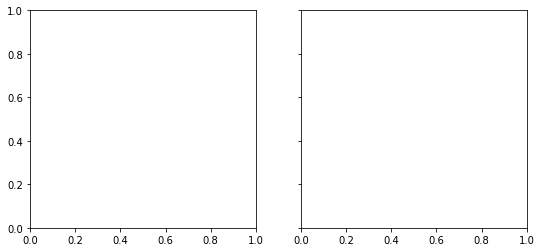

In [17]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharey=True)
purity = 1
x_min = 0
x_max = 1000
N = 19

#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['track_chi2_proton']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['track_chi2_proton']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'track_chi2_proton')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')

# Right
x_min = 0
x_max = 100
#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['track_chi2_muon']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['track_chi2_muon']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'track_chi2_muon')
ax[1].set_ylabel('Efficiency')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')



fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")
fig.savefig(outputdir+"eff.png", bbox_inches="tight")

In [ ]:
import collections
#a = tree_Daughter_nuCC.query(query_event)['mc_pdg']
# 2212=proton , 211=Pi+, 11=electron, 2112=neutron, 321=K+, 22=gamma, 3222=sigma+
counter=collections.Counter(tree_Daughter_nuCC.query(query_event)['mc_pdg'])
print(counter)

print 'Initial nues in fiducial volume:', sum(tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==12 & mc_nu_fid_vol') )

In [ ]:
for key in tree_Daughter_nuCC.columns: 
    print key
    if (key!='has_shower_daughter' and key!='is_track_daughter' and key!='track_mcs_err' and key!='track_mcs_ll') :
        plt.hist(tree_Daughter_nuCC.query(query_event)[key.decode("utf-8")], bins=50)
        plt.xlabel(key.decode("utf-8"))
        plt.show()